In [1]:
# 모듈 import

from mmcv import Config
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.datasets import (build_dataloader, build_dataset, replace_ImageToTensor)
from mmdet.utils import get_device

import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# config file 들고오기
cfg = Config.fromfile('./configs/faster_rcnn/custom_faster_rcnn.py')

root='/data/ephemeral/home/dataset/'

cfg.keys()

dict_keys(['model', 'img_scale', 'data_root', 'dataset_type', 'train_pipeline', 'train_dataset', 'test_pipeline', 'data', 'optimizer', 'optimizer_config', 'lr_config', 'runner', 'checkpoint_config', 'log_config', 'custom_hooks', 'dist_params', 'log_level', 'load_from', 'resume_from', 'workflow', 'opencv_num_threads', 'mp_start_method', 'auto_scale_lr'])

In [ ]:
cfg.data

In [ ]:
cfg.data.train

In [ ]:
cfg.data.train.pipeline

In [ ]:
cfg.data.train.dataset

In [ ]:
cfg.data.train.dataset.ann_file

In [ ]:
cfg.data.train.dataset.img_prefix

In [ ]:
cfg.data.train.pipeline

In [3]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# dataset config 수정

# cfg.data.train.classes = classes
cfg.data.train.dataset.classes = classes
# cfg.data.train.img_prefix = root
cfg.data.train.dataset.img_prefix = root
# cfg.data.train.ann_file = root + 'train.json' # train json 정보
cfg.data.train.dataset.ann_file = root + 'train.json' # train json 정보
# cfg.data.train.pipeline[2]['img_scale'] = (512,512) # Resize
cfg.data.train.pipeline[1]['img_scale'] = (512, 512)

'''
cfg.data.train.classes = classes
cfg.data.train.img_prefix = root
cfg.data.train.ann_file = root + 'train_split.json' # train json 정보
cfg.data.train.pipeline[2]['img_scale'] = (512,512) # Resize

cfg.data.val.classes = classes
cfg.data.val.img_prefix = root
cfg.data.val.ann_file = root + 'val_split.json' # train json 정보
cfg.data.val.pipeline[1]['img_scale'] = (512,512) # Resize
'''

cfg.data.test.classes = classes
cfg.data.test.img_prefix = root
cfg.data.test.ann_file = root + 'test.json' # test json 정보
cfg.data.test.pipeline[1]['img_scale'] = (512,512) # Resize

cfg.data.samples_per_gpu = 8 # 한 GPU가 학습 시 한 번에 처리할 이미지(샘플)의 개수(배치 크기 조절)
cfg.data.workers_per_gpu = 4 # 한 GPU가 데이터를 불러올 때 병렬로 작업할 워커(worker)의 수

cfg.seed = 2024
cfg.gpu_ids = [0]
cfg.work_dir = './work_dirs/custom_faster_rcnn_fpn_trash'

# cfg.model.roi_head.bbox_head.num_classes = 10

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2) # 학습 중 기울기 폭발을 방지하기 위해 사용
cfg.checkpoint_config = dict(max_keep_ckpts=3, interval=1) # 최대 3개의 체크포인트 파일을 유지

cfg.evaluation = dict(
    interval=1,
    metric='bbox',
    by_epoch=True
)

cfg.device = get_device()

In [4]:
# build_dataset

datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


In [5]:
# dataset 확인
datasets[0]

시각화

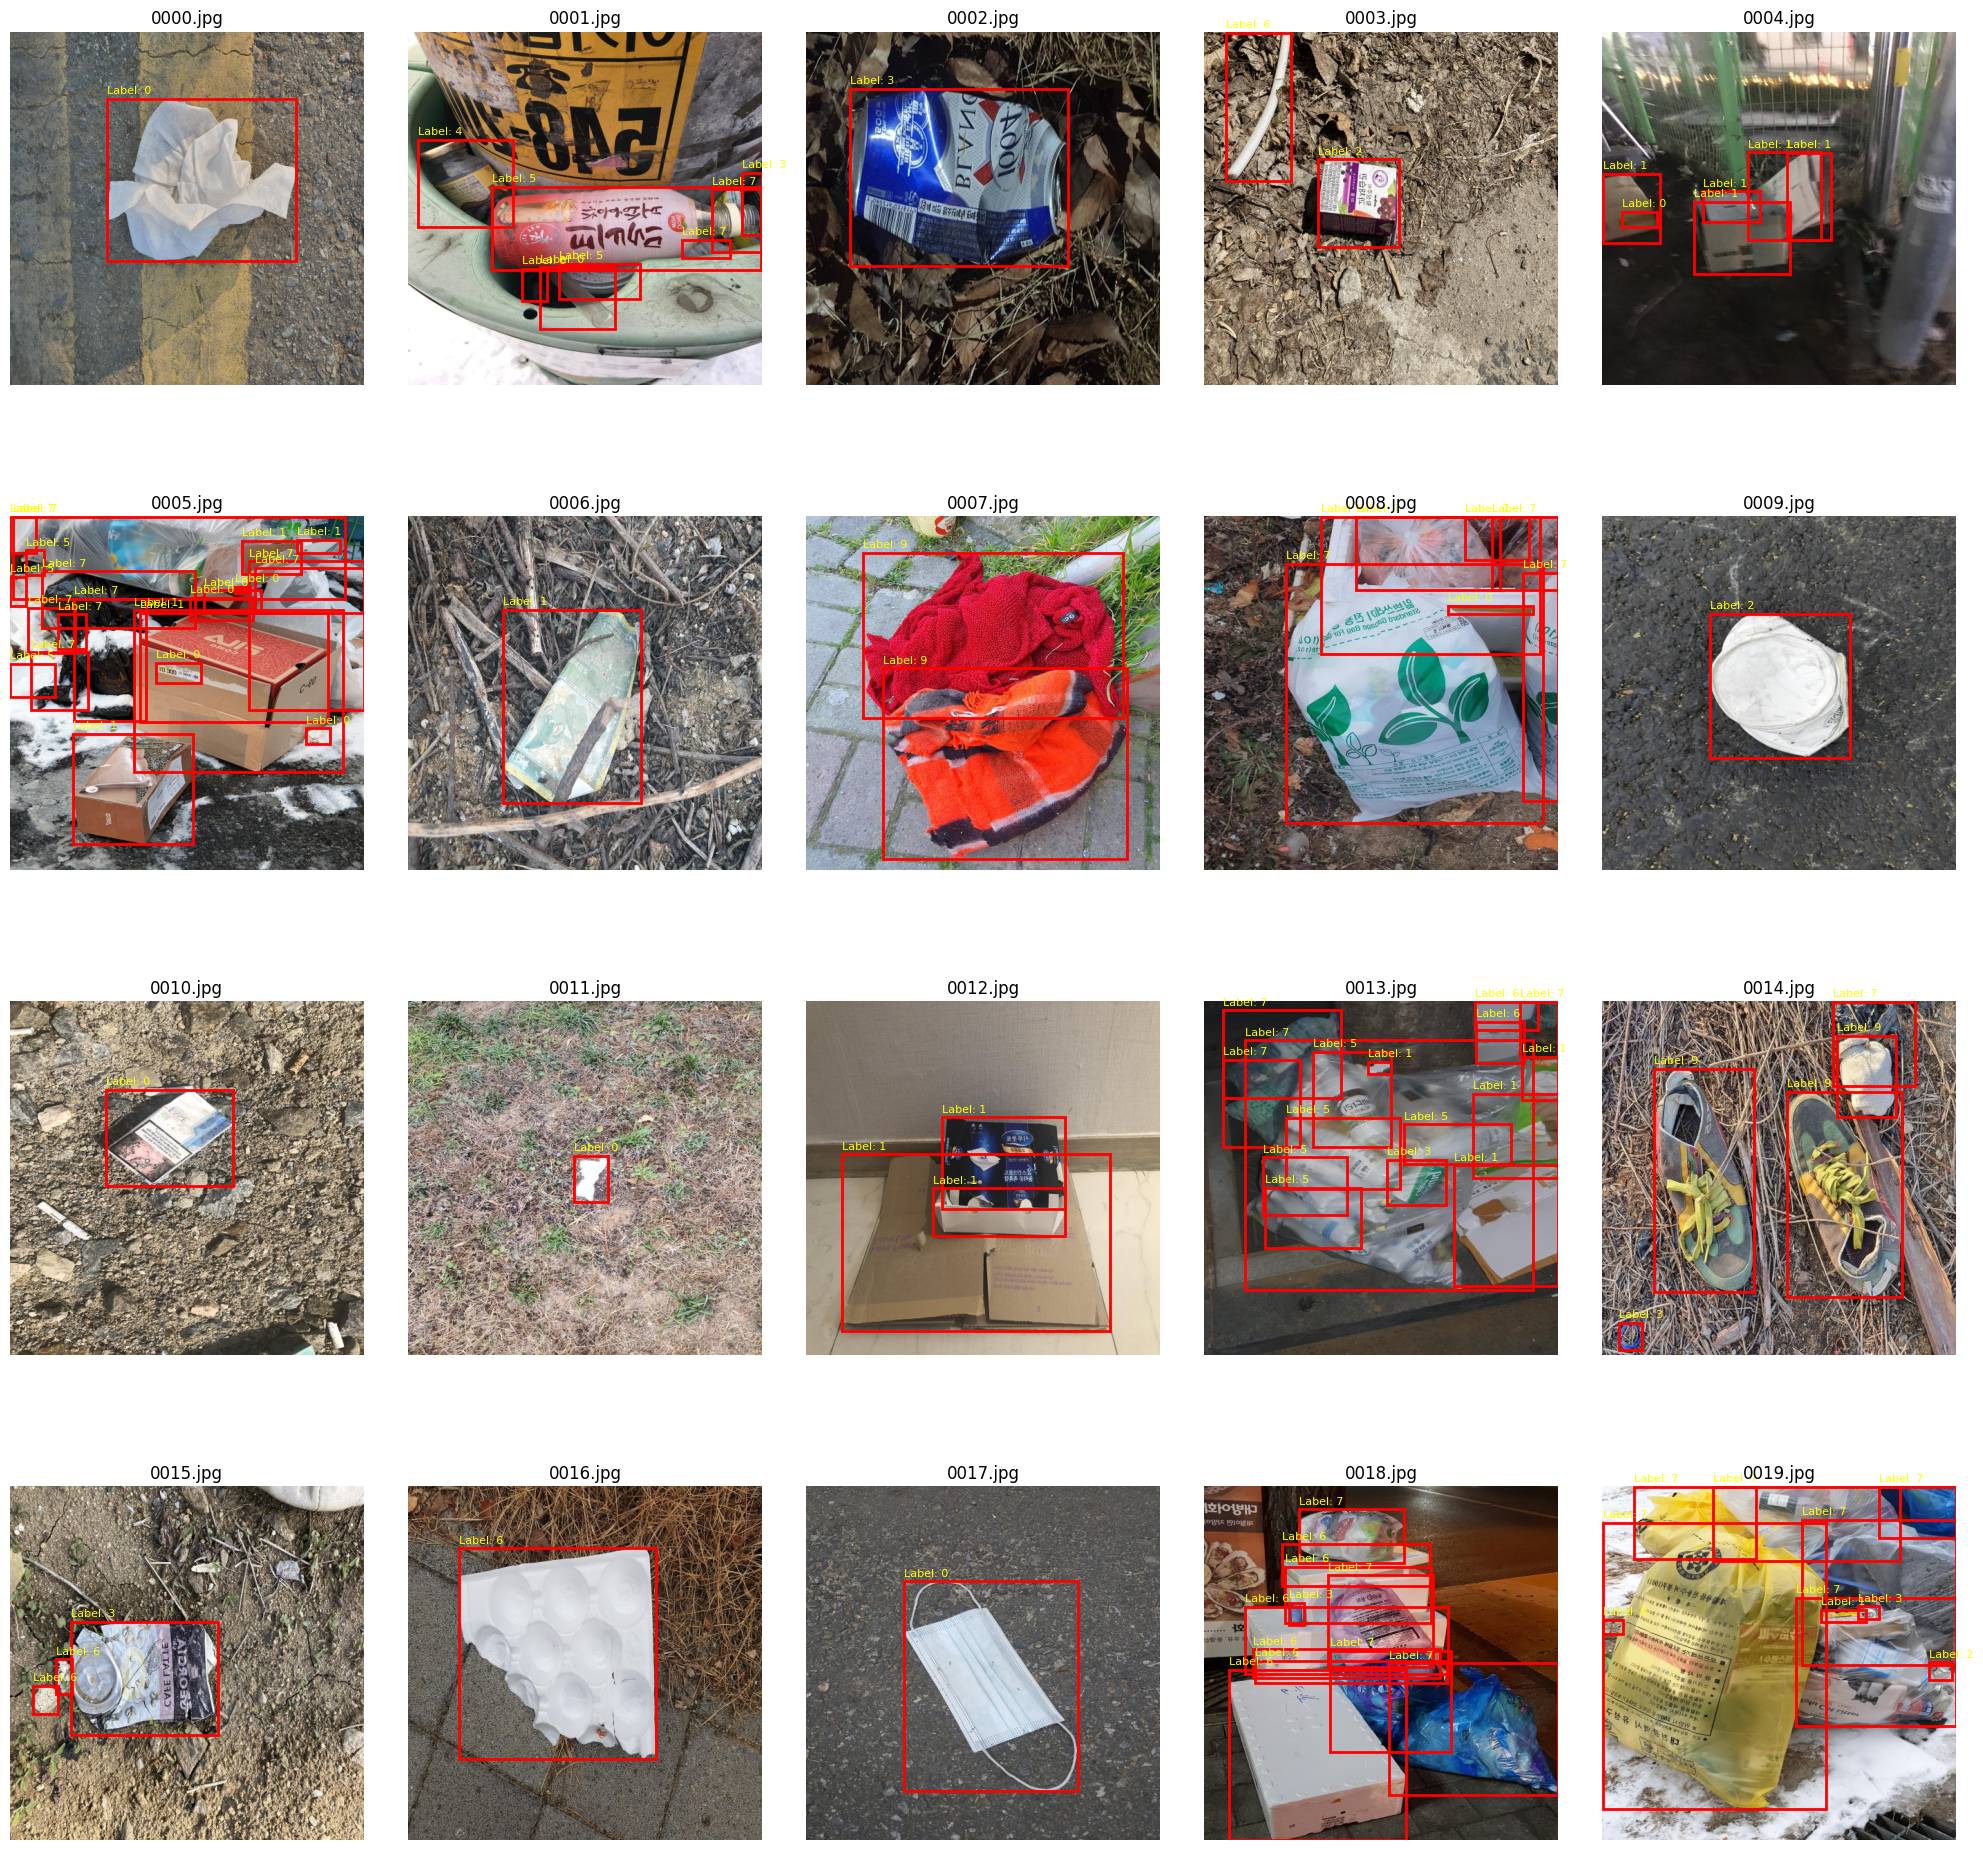

In [6]:
def visualize_selected_images(dataset, indices, cols=5):
    """선택된 인덱스에 해당하는 이미지와 바운딩 박스를 시각화."""
    num_images = len(indices)
    rows = num_images // cols + (num_images % cols > 0)

    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))  # 5x4 형태로 시각화
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        # 해당 인덱스 데이터 선택
        data = dataset[idx]

        img = data['img'].data.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
        img = img[..., ::-1]  # BGR -> RGB 변환
        img = img.astype(np.uint8)

        gt_bboxes = data['gt_bboxes'].data.numpy()
        gt_labels = data['gt_labels'].data.numpy()

        # 이미지 경로에서 파일명 추출
        img_path = data['img_metas'].data['filename']
        img_name = img_path.split('/')[-1]  # '/'로 split해서 마지막 부분 추출

        # 현재 subplot에 이미지 표시
        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')

        # 바운딩 박스 및 라벨 표시
        for bbox, label in zip(gt_bboxes, gt_labels):
            x1, y1, x2, y2 = bbox
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                       edgecolor='red', linewidth=2, fill=False))
            # 바운딩 박스 중앙에 라벨 표시
            ax.text(x1, y1 - 5, f'Label: {label}', color='yellow', fontsize=8, va='bottom')

        # 제목으로 이미지 파일명 표시
        ax.set_title(f"{img_name}")

    # 남은 빈 subplot 숨기기
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# 원하는 인덱스 20개 지정
indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

# 선택된 인덱스의 이미지 시각화
visualize_selected_images(datasets[0], indices=indices)


In [ ]:
# 모델 build 및 pretrained network 불러오기
model = build_detector(cfg.model)
model.init_weights()

In [ ]:
# 모델 학습
train_detector(model, datasets[0], cfg, distributed=False, validate=False)